# Codecademy "Building Agentic AI Applications for Beginners" (Assignment 1: Cancer screening machine learning exercise)

2026-01 : Jon C

The data file contained a list of *cancer screening patients* with features related to their:

* health habits (e.g. smoking and alcohol)
* living conditions (e.g. air pollution and occupation hazards)
* other medical variables

The data file also had a quantitative dependent variable:
* `Overall_Risk_Score`
  * when sorting any of the two columns, we could see:
    * `0.00 to 0.33` = Low risk
    * `0.33 to 0.66` = Medium risk
    * `0.66 to 1.00` = High risk
  * to ensure this, a correlation was calculated between the `Overall_Risk_Score` and `Risk_Level` features (see the "Data cleaning" section)

Our goals of this exercise:

* split data into training and testing data for use in multiple models
  * training data will form the basis of the models
  * testing data will see if the models
    * can predict the `Overall_Risk_Score` (`y_pred`)
    * ...by validating against the real `Overall_Risk_Score` (`y_test`)
  * get accuracy level of models
  * select the best model
* use the best model predict `Overall_Risk_Score`
* re-create the `Risk_Level` with that predicted score

## Setup

For the purposes of this exercise, we will use **Google Colab's secrets** to help point to the `.xlsx` data file located on a mounted Google Drive, as well as the `pandas` Python library to help us visualize our data:

In [13]:
import pandas as pd

# get data path from secrets
from google.colab import userdata
data_path = userdata.get('CANCER_PATH')

# load file onto data
data = pd.read_excel(data_path)

# size of dataset
len(data)

497

## Data understanding

Looking at the features of this spreadsheet file, we have the following options as independent variables (`X[i]`), not including the already discussed dependent feature, `Overall_Risk_Score` and the soon-to-be-discarded duplicate feature, `Risk_Level`:

* Patient_ID
* Cancer_Type
* Age
* Gender
* Smoking
* Alcohol_Use
* Obesity
* Family_History
* Diet_Red_Meat
* Diet_Salted_Processed
* Fruit_Veg_Intake
* Physical_Activity
* Air_Pollution
* Occupational_Hazards
* BRCA_Mutation
* H_Pylori_Infection
* Calcium_Intake
* BMI
* Physical_Activity_Level

The following variables seemed straightforward to be included in, say, a **linear regression model**, due to their labeling and already quantitative data types:

* `Age` (integer)
* `Smoking` (integer)
* `Alcohol_Use` (integer)
* `Obesity` (integer)
* `Family_History` (integer)
* `Diet_Red_Meat` (integer)
* `Diet_Salted_Processed` (integer)
* `Fruit_Veg_Intake` (integer)
* `Physical_Activity` (integer)
* `Air_Pollution` (integer)
* `Occupational_Hazards` (integer)
* `BRCA_Mutation` (integer / binary?)
* `H_Pylori_Infection` (integer / binary?)
* `Calcium_Intake` (integer)
* `BMI` (float)
* `Physical_Activity_Level` (integer)

### Clarifications

However, three features were deemed inappropriate for the model: the data provider (Satyajit Pattnaik) even mentioned [in this recording](https://www.codecademy.com/bootcamps/agai-1/recordings/16) at around the 2:22:00 mark:

* `Patient_ID` (string)
  - this was not useful to our prediction model as the value for each record was obviously used to uniquely identify each "patient"
  - SP recommended to remove this feature at 2:22:03
* `Cancer_Type` (string)
  - we would remove this variable because we are looking at overall risk rather than the risk of each type of cancer
  - SP recommended to remove this feature at 2:22:07

Also:

* `Gender` (binary)
  - we could include this variable but using a `0` for one gender and `1` for another gender might affect the model too greatly if they are to be multiplied by a coefficient
  - for this exercise we will simplify things and look at cancer risk _regardless of gender_

So, we will at first discard `Patient_ID` and `Cancer_Type` upon recommendation of the data provider; discard `Gender` due to its categorial nature...

### Correlation between `Overall_Risk_Score` and `Risk_Level`

Since `Risk_Level` is categorical, we first need to convert it into a numerical representation, before we do a correlation calculation:
* 'Low risk' to 0
* 'Medium risk' to 0.5
* 'High risk' to 1


In [14]:
# Create a numerical mapping for 'Risk_Level'
risk_level_mapping = {
    'Low': 0,
    'Medium': 0.5,
    'High': 1
}

# Apply the mapping to create a new numerical column
data['Risk_Level_Numeric'] = data['Risk_Level'].map(risk_level_mapping)

# Calculate the correlation between Overall_Risk_Score and the new numerical Risk_Level
correlation = data['Overall_Risk_Score'].corr(data['Risk_Level_Numeric'])

print(f"Correlation between Overall_Risk_Score and Risk_Level: {correlation:.4f}")

# Drop the temporary numerical Risk_Level column as it's not needed for further modeling
data = data.drop('Risk_Level_Numeric', axis=1)

Correlation between Overall_Risk_Score and Risk_Level: 0.9335


Thus, we will also discard `Risk_Level` as it more or less mirrors `Overall_Risk_Score`!

## Data collection

We'll have a brief look at the original data set to start:

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               497 non-null    object 
 1   Cancer_Type              497 non-null    object 
 2   Age                      497 non-null    int64  
 3   Gender                   497 non-null    int64  
 4   Smoking                  497 non-null    int64  
 5   Alcohol_Use              497 non-null    int64  
 6   Obesity                  497 non-null    int64  
 7   Family_History           497 non-null    int64  
 8   Diet_Red_Meat            497 non-null    int64  
 9   Diet_Salted_Processed    497 non-null    int64  
 10  Fruit_Veg_Intake         497 non-null    int64  
 11  Physical_Activity        497 non-null    int64  
 12  Air_Pollution            497 non-null    int64  
 13  Occupational_Hazards     497 non-null    int64  
 14  BRCA_Mutation            4

## Data cleaning

### Noisy data

As per the "Data understanding" section of this report, we will remove the following features:

* `Patient_ID` (unique identifier)
* `Cancer_Type` (temporarily removing due to qualitative nature of variable)
* `Gender` (temporarily removing due to its confounding nature)
* `Risk_Level` (a qualitative duplication of `Overall_Risk_Score`)

The correlation between `Overall_Risk_Score` and `Risk_Level` is `0.9335`, which indicates a very strong positive linear relationship! Thus, we can remove `Risk_level` and use `Overall_Risk_Score` as the dependent y variable ... later, we can use the score to determine the level!

In [16]:
# === data cleaning

data = data.drop('Patient_ID', axis= 1)   # not quantitative
data = data.drop('Cancer_Type', axis= 1)  # doubt because of categorical nature (not truly quantitative)
data = data.drop('Gender', axis= 1)       # doubt because of categorical nature (not truly quantitative)
data = data.drop('Risk_Level', axis= 1)   # somewhat redundant
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      497 non-null    int64  
 1   Smoking                  497 non-null    int64  
 2   Alcohol_Use              497 non-null    int64  
 3   Obesity                  497 non-null    int64  
 4   Family_History           497 non-null    int64  
 5   Diet_Red_Meat            497 non-null    int64  
 6   Diet_Salted_Processed    497 non-null    int64  
 7   Fruit_Veg_Intake         497 non-null    int64  
 8   Physical_Activity        497 non-null    int64  
 9   Air_Pollution            497 non-null    int64  
 10  Occupational_Hazards     497 non-null    int64  
 11  BRCA_Mutation            497 non-null    int64  
 12  H_Pylori_Infection       497 non-null    int64  
 13  Calcium_Intake           497 non-null    int64  
 14  Overall_Risk_Score       4

## Model preparation

Let's separate our designated dependent variable, `Overall_Risk_Score` from the independent variables:

In [17]:
# === model preparation (training and testing data split)

from sklearn.model_selection import train_test_split

X = data.drop(['Overall_Risk_Score'], axis=1)
y = data['Overall_Risk_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("Training dataset size: ", len(X_train))
print("Testing dataset size: ", len(X_test))
print("Maximum y_train value: ", y_train.max())
print("Minimum y_train value: ", y_train.min())
print("Maximum y_test value: ", y_test.max())
print("Minimum y_test value: ", y_test.min())

Training dataset size:  397
Testing dataset size:  100
Maximum y_train value:  0.852158468
Minimum y_train value:  0.029284507
Maximum y_test value:  0.75302407
Minimum y_test value:  0.16375952


### Feature scaling

Since `Overall_Risk_Score`s are already scale of 0 to 1, this step is redundant!

## Model building

We will try a few model types:
* linear regression
* random forest
* adaboost
* lasso regression

### Linear regression

In [18]:
from sklearn.linear_model import LinearRegression

# model choice (linear regression)
model_slr = LinearRegression()
model_slr = model_slr.fit(X_train,y_train)

# regression equation building
print("Intercept:", model_slr.intercept_)
print("Coefficients:", model_slr.coef_)
feature_names = X_train.columns
coefficients = model_slr.coef_
print("\nRegression equation:")
print(f"Overall_Risk_Score = {model_slr.intercept_:.4f}", end="\n")
for i, feature in enumerate(feature_names):
    print(f" + {coefficients[i]:.4f} * {feature}", end="\n")
print()

# predicting y with 20% of test data, X (ignoring the "real" y)
y_pred = model_slr.predict(X_test)

# reset indices
y_pred = pd.Series(y_pred).reset_index(drop=True)

Intercept: -0.05162942083077271
Coefficients: [ 2.30048566e-04  1.40729374e-02  1.48831096e-02  1.19864300e-02
  2.04788029e-02  1.42522290e-02  1.44369852e-02 -1.35383292e-03
 -8.79862561e-04  1.48203131e-02  1.26573478e-02  2.79789784e-02
  4.98125775e-03 -3.00534572e-04  6.17199343e-06 -1.09665106e-03]

Regression equation:
Overall_Risk_Score = -0.0516
 + 0.0002 * Age
 + 0.0141 * Smoking
 + 0.0149 * Alcohol_Use
 + 0.0120 * Obesity
 + 0.0205 * Family_History
 + 0.0143 * Diet_Red_Meat
 + 0.0144 * Diet_Salted_Processed
 + -0.0014 * Fruit_Veg_Intake
 + -0.0009 * Physical_Activity
 + 0.0148 * Air_Pollution
 + 0.0127 * Occupational_Hazards
 + 0.0280 * BRCA_Mutation
 + 0.0050 * H_Pylori_Infection
 + -0.0003 * Calcium_Intake
 + 0.0000 * BMI
 + -0.0011 * Physical_Activity_Level



From what we see in the regression equation above, we notice:

* age isn't a big factor (1/5000 ratio of 0.0002)
* on the other hand the following have higher coefficients, contributing more to the score (around a 1/30 to a 1/100 ratio):
  * smoking
  * alcohol use
  * obesity
  * family history
  * diet of red meat
  * diet of salted/processed foods
  * air pollution
  * occupational hazards
  * BRCA mutation
* while these also have low coefficients, contributing less to the score:
  * fruit veg intake
  * physical activity
  * h_pylori infection
  * calcium intake
  * bmi
  * physical activity level
* worth noting, however, these had _negative_ coefficients (the more intake, the less risk!), however low the magnitude, meaning that these _lower_ the risk of cancer:
  * fruit and vegetable intake
  * physical activity
  * calcium intake
  * physical activity level

Now that we have created our regression equation, we can run it through the testing data and predict its score; then, we can compare those predicted scores with the actual scores...

#### Linear regression (model evaluation)

More objectively, we can evaluate the model mathematically by running through three tests:

* Mean absolute error (MAE)
* Mean squared error (MSE)
* Root mean squared error (RMSE)

The closer to 0 each of these scores, the better:

In [19]:
## === model evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

mae1 = mean_absolute_error(y_pred, y_test)
mse1 = mean_squared_error(y_pred, y_test)
rmse1 = root_mean_squared_error(y_pred, y_test)

metrics1 = [ ("Mean absolute error (MAE)", mae1), ("Mean squared error (MSE)", mse1), ("Root mean squared error (RMSE)", rmse1) ]

for name, metric_value in metrics1:
  print(f"{name}: {metric_value:.4f}")

Mean absolute error (MAE): 0.0415
Mean squared error (MSE): 0.0031
Root mean squared error (RMSE): 0.0557


To see just how fitted the model is to the actual scores, we can plot them in this line graph:

In [20]:
# comparing y_pred with y_test, we can see the prediction data corresponds almost with the test data
df1 = pd.DataFrame(y_pred)
df2 = pd.DataFrame(y_test)
df_comparison = pd.concat([df1, df2.reset_index(drop=True)], axis=1)
df_comparison.columns = ['Predicted_Risk_Score (regression)', 'Actual_Risk_Score (from data)']
df_comparison['Difference'] = df_comparison['Predicted_Risk_Score (regression)'] - df_comparison['Actual_Risk_Score (from data)']
display(df_comparison)

,Predicted_Risk_Score (regression),Actual_Risk_Score (from data),Difference
0,0.434917,0.422675,0.012242
1,0.488189,0.460497,0.027692
2,0.307031,0.303528,0.003503
3,0.483092,0.562853,-0.079761
4,0.323165,0.329922,-0.006757
...,...,...,...
95,0.276244,0.328424,-0.052180
96,0.630505,0.708873,-0.078368
97,0.347076,0.305616,0.041460
98,0.549372,0.551049,-0.001677


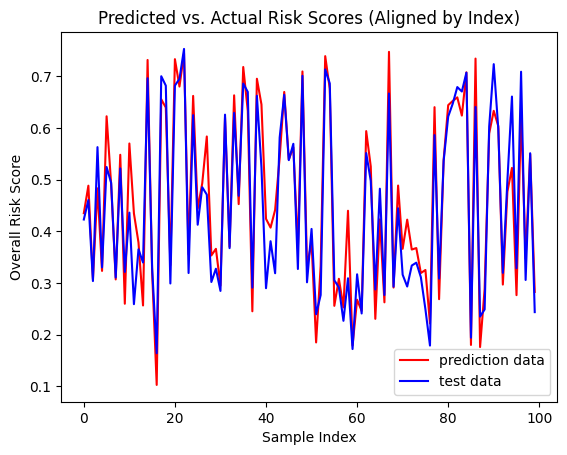

In [21]:
import matplotlib.pyplot as plt

# graph the y of the test data entries with the predicted y for the test entries
plt.plot(df_comparison['Predicted_Risk_Score (regression)'], color='red', label='prediction data')
plt.plot(df_comparison['Actual_Risk_Score (from data)'], color='blue', label='test data')
plt.xlabel('Sample Index')
plt.ylabel('Overall Risk Score')
plt.title('Predicted vs. Actual Risk Scores (Aligned by Index)')
plt.legend()
plt.show()

### Random forest

Let's build and evaluate a Random Forest Regressor model to see how it compares to the Linear Regression model:

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor model
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

print("Random Forest model trained!")

Random Forest model trained!


In [23]:
# Predict y with the test data using the Random Forest model
y_pred_rf = model_rf.predict(X_test)

# reset indices for comparison
y_pred_rf = pd.Series(y_pred_rf).reset_index(drop=True)

In [24]:
# comparing y_pred_rf with y_test
df_comparison_rf = pd.DataFrame({'Predicted_Risk_Score (Random Forest)': y_pred_rf, 'Actual_Risk_Score (from data)': y_test.reset_index(drop=True)})
df_comparison_rf['Difference'] = df_comparison_rf['Predicted_Risk_Score (Random Forest)'] - df_comparison_rf['Actual_Risk_Score (from data)']
display(df_comparison_rf)

,Predicted_Risk_Score (Random Forest),Actual_Risk_Score (from data),Difference
0,0.485272,0.422675,0.062597
1,0.466161,0.460497,0.005665
2,0.295463,0.303528,-0.008065
3,0.477062,0.562853,-0.085791
4,0.327297,0.329922,-0.002626
...,...,...,...
95,0.273233,0.328424,-0.055191
96,0.586368,0.708873,-0.122506
97,0.294010,0.305616,-0.011606
98,0.548180,0.551049,-0.002868


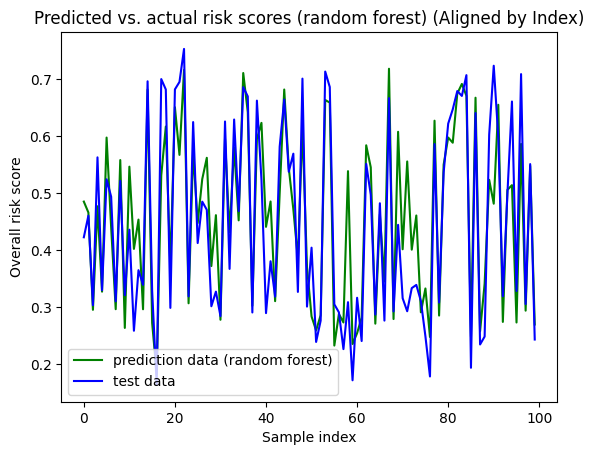

In [25]:
import matplotlib.pyplot as plt

# Graph the y of the test data entries with the predicted y for the test entries from Random Forest
plt.plot(df_comparison_rf['Predicted_Risk_Score (Random Forest)'], color='green', label='prediction data (random forest)')
plt.plot(df_comparison_rf['Actual_Risk_Score (from data)'], color='blue', label='test data')
plt.xlabel('Sample index')
plt.ylabel('Overall risk score')
plt.title('Predicted vs. actual risk scores (random forest) (Aligned by Index)')
plt.legend()
plt.show()

#### Random forest (model evaluation)

Let's evaluate the Random Forest model using MAE, MSE, and RMSE:

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

mae_rf = mean_absolute_error(y_pred_rf, y_test)
mse_rf = mean_squared_error(y_pred_rf, y_test)
rmse_rf = root_mean_squared_error(y_pred_rf, y_test)

metrics_rf = [ ("Mean absolute error (MAE) (Random forest)", mae_rf),
               ("Mean squared error (MSE) (Random forest)", mse_rf),
               ("Root mean squared error (RMSE) (Random forest)", rmse_rf) ]

print("\nRandom forest:")
for name, metric_value in metrics_rf:
  print(f"{name}: {metric_value:.4f}")

print("\nLinear regression model for comparison:")
for name, metric_value in metrics1:
  print(f"{name}: {metric_value:.4f}")


Random forest:
Mean absolute error (MAE) (Random forest): 0.0597
Mean squared error (MSE) (Random forest): 0.0062
Root mean squared error (RMSE) (Random forest): 0.0787

Linear regression model for comparison:
Mean absolute error (MAE): 0.0415
Mean squared error (MSE): 0.0031
Root mean squared error (RMSE): 0.0557


Surprisingly, the Random forest has a higher error than the linear regression; we shall try another model to see if we can get an error closer to 0!

### Adaboost

Let's try a "boosting" model:

In [27]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the AdaBoost Regressor model
# Using a Decision Tree as the base estimator
model_ab = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4), random_state=42)
model_ab.fit(X_train, y_train)

print("AdaBoost model trained!")

AdaBoost model trained!


In [28]:
# Predict y with the test data using the AdaBoost model
y_pred_ab = model_ab.predict(X_test)

# reset indices for comparison
y_pred_ab = pd.Series(y_pred_ab).reset_index(drop=True)

In [29]:
# comparing y_pred_ab with y_test
df_comparison_ab = pd.DataFrame({'Predicted_Risk_Score (AdaBoost)': y_pred_ab, 'Actual_Risk_Score (from data)': y_test.reset_index(drop=True)})
df_comparison_ab['Difference'] = df_comparison_ab['Predicted_Risk_Score (AdaBoost)'] - df_comparison_ab['Actual_Risk_Score (from data)']
display(df_comparison_ab)

,Predicted_Risk_Score (AdaBoost),Actual_Risk_Score (from data),Difference
0,0.465853,0.422675,0.043179
1,0.461936,0.460497,0.001440
2,0.283232,0.303528,-0.020296
3,0.430061,0.562853,-0.132792
4,0.337326,0.329922,0.007404
...,...,...,...
95,0.278459,0.328424,-0.049965
96,0.608795,0.708873,-0.100078
97,0.283232,0.305616,-0.022384
98,0.494018,0.551049,-0.057031


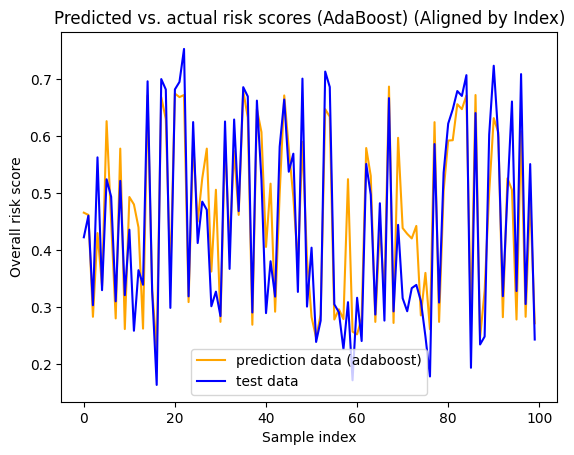

In [30]:
import matplotlib.pyplot as plt

# Graph the y of the test data entries with the predicted y for the test entries from AdaBoost
plt.plot(df_comparison_ab['Predicted_Risk_Score (AdaBoost)'], color='orange', label='prediction data (adaboost)')
plt.plot(df_comparison_ab['Actual_Risk_Score (from data)'], color='blue', label='test data')
plt.xlabel('Sample index')
plt.ylabel('Overall risk score')
plt.title('Predicted vs. actual risk scores (AdaBoost) (Aligned by Index)')
plt.legend()
plt.show()

#### Adaboost (model evaluation)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

mae_ab = mean_absolute_error(y_pred_ab, y_test)
mse_ab = mean_squared_error(y_pred_ab, y_test)
rmse_ab = root_mean_squared_error(y_pred_ab, y_test)

metrics_ab = [ ("Mean absolute error (MAE) (AdaBoost)", mae_ab),
               ("Mean squared error (MSE) (AdaBoost)", mse_ab),
               ("Root mean squared error (RMSE) (AdaBoost)", rmse_ab) ]

print("\nAdaBoost:")
for name, metric_value in metrics_ab:
  print(f"{name}: {metric_value:.4f}")

print("\nRandom forest for comparison:")
for name, metric_value in metrics_rf:
  print(f"{name}: {metric_value:.4f}")

print("\nLinear regression model for comparison:")
for name, metric_value in metrics1:
  print(f"{name}: {metric_value:.4f}")


AdaBoost:
Mean absolute error (MAE) (AdaBoost): 0.0569
Mean squared error (MSE) (AdaBoost): 0.0053
Root mean squared error (RMSE) (AdaBoost): 0.0727

Random forest for comparison:
Mean absolute error (MAE) (Random forest): 0.0597
Mean squared error (MSE) (Random forest): 0.0062
Root mean squared error (RMSE) (Random forest): 0.0787

Linear regression model for comparison:
Mean absolute error (MAE): 0.0415
Mean squared error (MSE): 0.0031
Root mean squared error (RMSE): 0.0557


Adaboost fared slightly better than the random forest model, but still not as great as the linear regression!

### Lasso Regression

Let's try another regression model:

In [32]:
from sklearn.linear_model import Lasso

# Initialize and train the Lasso Regressor model
# You might need to tune the 'alpha' parameter for optimal performance
model_lasso = Lasso(alpha=0.01, random_state=42) # alpha is the regularization strength
model_lasso.fit(X_train, y_train)

print("Lasso model trained!")

Lasso model trained!


In [33]:
# Predict y with the test data using the Lasso model
y_pred_lasso = model_lasso.predict(X_test)

# reset indices for comparison
y_pred_lasso = pd.Series(y_pred_lasso).reset_index(drop=True)

In [34]:
# comparing y_pred_lasso with y_test
df_comparison_lasso = pd.DataFrame({'Predicted_Risk_Score (Lasso)': y_pred_lasso, 'Actual_Risk_Score (from data)': y_test.reset_index(drop=True)})
df_comparison_lasso['Difference'] = df_comparison_lasso['Predicted_Risk_Score (Lasso)'] - df_comparison_lasso['Actual_Risk_Score (from data)']
display(df_comparison_lasso)

,Predicted_Risk_Score (Lasso),Actual_Risk_Score (from data),Difference
0,0.447256,0.422675,0.024581
1,0.494853,0.460497,0.034356
2,0.310644,0.303528,0.007116
3,0.496144,0.562853,-0.066709
4,0.334564,0.329922,0.004642
...,...,...,...
95,0.290622,0.328424,-0.037802
96,0.630258,0.708873,-0.078615
97,0.357836,0.305616,0.052221
98,0.557657,0.551049,0.006608


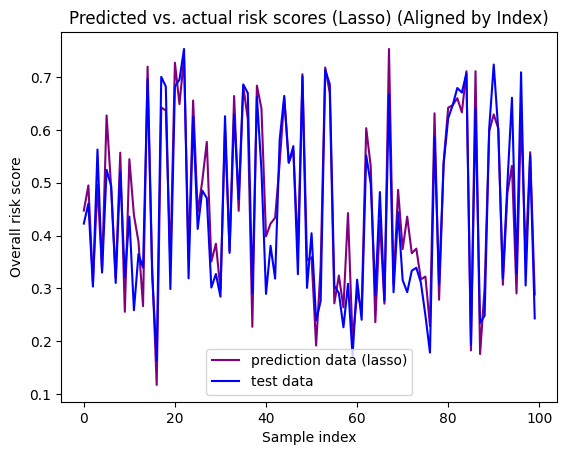

In [35]:
import matplotlib.pyplot as plt

# Graph the y of the test data entries with the predicted y for the test entries from Lasso
plt.plot(df_comparison_lasso['Predicted_Risk_Score (Lasso)'], color='purple', label='prediction data (lasso)')
plt.plot(df_comparison_lasso['Actual_Risk_Score (from data)'], color='blue', label='test data')
plt.xlabel('Sample index')
plt.ylabel('Overall risk score')
plt.title('Predicted vs. actual risk scores (Lasso) (Aligned by Index)')
plt.legend()
plt.show()

#### Lasso Regression (model evaluation)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

mae_lasso = mean_absolute_error(y_pred_lasso, y_test)
mse_lasso = mean_squared_error(y_pred_lasso, y_test)
rmse_lasso = root_mean_squared_error(y_pred_lasso, y_test)

metrics_lasso = [ ("Mean absolute error (MAE) (Lasso)", mae_lasso),
                  ("Mean squared error (MSE) (Lasso)", mse_lasso),
                  ("Root mean squared error (RMSE) (Lasso)", rmse_lasso) ]

print("\nLasso Regression:")
for name, metric_value in metrics_lasso:
  print(f"{name}: {metric_value:.4f}")


Lasso Regression:
Mean absolute error (MAE) (Lasso): 0.0426
Mean squared error (MSE) (Lasso): 0.0031
Root mean squared error (RMSE) (Lasso): 0.0552


Lasso regression seems very similar to linear regression, with only its errors slightly lower...



The mean error is below 0.33 (the size of each category of "Low", "Medium" or "High", so if a score is close to 0.33 or 0.66, it could cause some "Low" risk levels to be bumped up to a "Medium" (or vice versa), or a "Medium" up to a "High" (or vice versa)

However, since the categories have a gap of 0.33, a 0.0426 mean absolute error implies that a "Low" risk patient would never actually be a "High" risk patient (or vice versa)! Thus, we will also add new patient risk levels with borderline categories (e.g. "Low to medium" or "Medium to high) to give further insight!

## Model decision

While many other models exist, of the 4 models we have used, we see that the regression models have the best error scores:

In [37]:
import pandas as pd

# Create a dictionary to hold the metrics for each model
metrics_data = {
    'Model': ['Linear Regression', 'Random Forest', 'AdaBoost', 'Lasso Regression'],
    'MAE': [mae1, mae_rf, mae_ab, mae_lasso],
    'MSE': [mse1, mse_rf, mse_ab, mse_lasso],
    'RMSE': [rmse1, rmse_rf, rmse_ab, rmse_lasso]
}

# Create a DataFrame from the metrics data
df_metrics_summary = pd.DataFrame(metrics_data)

# Display the DataFrame, sorted by RMSE for easy comparison of 'accuracy'
display(df_metrics_summary.sort_values(by='RMSE'))

,Model,MAE,MSE,RMSE
3,Lasso Regression,0.042562,0.003052,0.055246
0,Linear Regression,0.041488,0.003103,0.055705
2,AdaBoost,0.056890,0.005286,0.072705
1,Random Forest,0.059725,0.006196,0.078713


## Model exploration

After looking through 4 randomly chosen models, the best fit model was lasso regression ... we'll now use it to predict a patient's cancer risk level with 16 different variables:

In [38]:
import warnings
import pandas as pd

# sample entry for prediction
# order of features must match the order in X_train
# features include:
# [ Age, Smoking (0 to 10), Alcohol_Use (0 to 10), Obesity (0 to 10), Family_History (0 or 1), ...
#   Diet_Red_Meat (0 to 10), Diet_Salted_Processed (0 to 10), Fruit_Veg_Intake (0 to 10), Physical_Activity (0 to 10), ...
#   Air_Pollution (0 to 10), Occupational_Hazards (0 to 10), BRCA_Mutation (0 or 1), H_Pylori_Infection (0 or 1),
#   Calcium_Intake (0 to 10), BMI (15 to 36.9), Physical_Activity_Level (0 to 10)]

sample_data = [[
    41, 0, 0, 10, 1,
    7, 9, 9, 0,
    5, 5, 0, 0,
    5, 37, 0
]]

sample_df = pd.DataFrame(sample_data)

# suppress the specific UserWarning from sklearn about feature names
with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    # make a prediction with the linear regression model
    single_prediction = model_lasso.predict(sample_df)

# print the predicted Overall_Risk_Score
print("overall risk score: ", single_prediction)

# let's now assign intrepretations "low/low-medium/medium/medium-high/high risk"
if single_prediction >= 0.66 + mae_lasso:
  print("high risk")
elif single_prediction >= 0.66 - mae_lasso and single_prediction < 0.66 + mae_lasso:
  print("medium to high risk")
elif single_prediction >= 0.33 + mae_lasso and single_prediction < 0.66 - mae_lasso:
  print("medium risk")
elif single_prediction >= 0.33 - mae_lasso and single_prediction < 0.33 + mae_lasso:
  print("low to medium risk")
elif single_prediction > 0 and single_prediction < 0.33 - mae_lasso:
  print("low risk")
else:
  print("error: prediction is not between 0 and 1")


overall risk score:  [0.43236333]
medium risk


## Conclusions

As we know from common knowledge, which was reaffirmed by performing machine learning on the data of several patients, the following factors increase the overall risk of _any type_ of cancer (disregarding cancer type and patient gender):

* smoking intake
* alcohol intake
* diets of red meat
* diets of processed foods
* previous family history  
* obesity

Other factors include:

* air pollution
* workplace hazards

Not surprisingly, the following actually decrease the risk, but not by much:

* vegetable intake
* calcium instake
* physical activity

We could also further break down this study by specific cancer type to try to find specific regression models for cancer types!